In [1]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
# For reproducibility
np.random.seed(1234)

Using TensorFlow backend.
/Users/fangche@cisco.com/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/fangche@cisco.com/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/fangche@cisco.com/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/U

In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [3]:
newsgroups_train.target
newsgroups_train.filenames

array(['/Users/fangche@cisco.com/scikit_learn_data/20news_home/20news-bydate-train/rec.autos/102994',
       '/Users/fangche@cisco.com/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.mac.hardware/51861',
       '/Users/fangche@cisco.com/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.mac.hardware/51879',
       ...,
       '/Users/fangche@cisco.com/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.ibm.pc.hardware/60695',
       '/Users/fangche@cisco.com/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38319',
       '/Users/fangche@cisco.com/scikit_learn_data/20news_home/20news-bydate-train/rec.motorcycles/104440'],
      dtype='<U105')

In [4]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
data_path = '20news-bydate/'
files_train = newsgroups_train
label_index = files_train.target
label_names = files_train.target_names
labelled_files = files_train.filenames


print(label_index[1],label_names[label_index[1]])
Path(labelled_files[0]).read_text()



4 comp.sys.mac.hardware


"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [6]:
data_tags = ["filename","category","news"]
data_list = []
i=0
for f in labelled_files:
    data_list.append((f,label_names[label_index[i]],Path(f).read_text(encoding = "ISO-8859-1")))
    i += 1

# We have training data available as dictionary filename, category, data
data = pd.DataFrame.from_records(data_list, columns=data_tags)



In [7]:
data
# at this point we have all the data 

,filename,category,news
0,/Users/fangche@cisco.com/scikit_learn_data/20n...,rec.autos,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,/Users/fangche@cisco.com/scikit_learn_data/20n...,comp.sys.mac.hardware,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,/Users/fangche@cisco.com/scikit_learn_data/20n...,comp.sys.mac.hardware,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,/Users/fangche@cisco.com/scikit_learn_data/20n...,comp.graphics,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,/Users/fangche@cisco.com/scikit_learn_data/20n...,sci.space,From: jcm@head-cfa.harvard.edu (Jonathan McDow...
...,...,...,...
11309,/Users/fangche@cisco.com/scikit_learn_data/20n...,sci.med,From: jim.zisfein@factory.com (Jim Zisfein) \n...
11310,/Users/fangche@cisco.com/scikit_learn_data/20n...,comp.sys.mac.hardware,From: ebodin@pearl.tufts.edu\nSubject: Screen ...
11311,/Users/fangche@cisco.com/scikit_learn_data/20n...,comp.sys.ibm.pc.hardware,From: westes@netcom.com (Will Estes)\nSubject:...
11312,/Users/fangche@cisco.com/scikit_learn_data/20n...,comp.graphics,From: steve@hcrlgw (Steven Collins)\nSubject: ...


In [8]:
# 20 news groups, define the parameters
num_labels = 20
vocab_size = 15000
batch_size = 100
num_epochs = 30

In [9]:
# we let 80% data for training and 20% for testing
train_size = int(len(data)*0.8)
train_posts = data['news'][:train_size]
train_tags = data['category'][:train_size]
train_files_names = data['filename'][:train_size]

In [10]:
test_posts = data['news'][train_size:]
test_tags = data['category'][train_size:]
test_files_names = data['filename'][train_size:]

In [11]:
# see the distribution of data, there isn't much data imbalance
train_tags.value_counts(normalize=True) * 100

comp.windows.x              5.435863
rec.motorcycles             5.413766
comp.sys.ibm.pc.hardware    5.314330
rec.sport.baseball          5.314330
soc.religion.christian      5.292233
sci.med                     5.270136
rec.autos                   5.270136
comp.sys.mac.hardware       5.259087
rec.sport.hockey            5.248039
sci.crypt                   5.236990
comp.os.ms-windows.misc     5.225942
sci.electronics             5.214893
misc.forsale                5.192796
comp.graphics               5.148602
talk.politics.mideast       5.038117
sci.space                   5.004972
talk.politics.guns          4.795050
alt.atheism                 4.176334
talk.politics.misc          3.911170
talk.religion.misc          3.237211
Name: category, dtype: float64

In [12]:
test_posts

9051     From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...
9052     From: rtsbangi@msuvx1.memst.edu\nSubject: ****...
9053     From: wagner@grace.math.uh.edu (David Wagner)\...
9054     From: dzk@cs.brown.edu (Danny Keren)\nSubject:...
9055     From: dbm0000@tm0006.lerc.nasa.gov (David B. M...
                               ...                        
11309    From: jim.zisfein@factory.com (Jim Zisfein) \n...
11310    From: ebodin@pearl.tufts.edu\nSubject: Screen ...
11311    From: westes@netcom.com (Will Estes)\nSubject:...
11312    From: steve@hcrlgw (Steven Collins)\nSubject: ...
11313    From: gunning@cco.caltech.edu (Kevin J. Gunnin...
Name: news, Length: 2263, dtype: object

In [13]:
# following are two examples of tokenizer, 
# example of us it to assign number to each letter
t  = Tokenizer()
text = "The earth is an awesome place live"
t.fit_on_texts(text)
test_text = "The earth is an great place live"
sequences = t.texts_to_sequences(test_text)
print(sequences)
print(t.word_index)

[[3], [4], [1], [], [1], [2], [8], [3], [4], [], [5], [6], [], [2], [9], [], [], [8], [1], [2], [3], [], [13], [7], [2], [14], [1], [], [7], [5], [15], [1]]
{'e': 1, 'a': 2, 't': 3, 'h': 4, 'i': 5, 's': 6, 'l': 7, 'r': 8, 'n': 9, 'w': 10, 'o': 11, 'm': 12, 'p': 13, 'c': 14, 'v': 15}


In [14]:
# example of using tokenizer to assign number to each word
t  = Tokenizer()
fit_text = ["The earth is an awesome place live \n the \n"]
t.fit_on_texts(fit_text)
test_text = ["The earth is live haha"]
print('word index',t.word_index)
print(t.texts_to_matrix(fit_text, mode='tfidf'))
print(t.texts_to_matrix(test_text, mode='tfidf'))

print(t.texts_to_matrix(fit_text, mode='binary'))

# first call the function is to fit sequence, after that is inference
print(t.texts_to_sequences(fit_text))
print(t.texts_to_sequences(test_text)) # 注意如果在字典里没有出现， 那么就不会出现这个词

word index {'the': 1, 'earth': 2, 'is': 3, 'an': 4, 'awesome': 5, 'place': 6, 'live': 7}
[[0.         0.6865121  0.40546511 0.40546511 0.40546511 0.40546511
  0.40546511 0.40546511]]
[[0.         0.40546511 0.40546511 0.40546511 0.         0.
  0.         0.40546511]]
[[0. 1. 1. 1. 1. 1. 1. 1.]]
[[1, 2, 3, 4, 5, 6, 7, 1]]
[[1, 2, 3, 7]]


In [15]:
# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)

In [16]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 "'ax": 4,
 'a': 5,
 'and': 6,
 'in': 7,
 'i': 8,
 'is': 9,
 'that': 10,
 'it': 11,
 'for': 12,
 'you': 13,
 'from': 14,
 'edu': 15,
 'on': 16,
 'this': 17,
 'be': 18,
 'are': 19,
 'not': 20,
 'have': 21,
 'with': 22,
 'as': 23,
 'or': 24,
 '1': 25,
 'was': 26,
 'if': 27,
 'but': 28,
 'they': 29,
 'subject': 30,
 'com': 31,
 'lines': 32,
 'at': 33,
 'by': 34,
 'organization': 35,
 'an': 36,
 '2': 37,
 'can': 38,
 'my': 39,
 '3': 40,
 'what': 41,
 'x': 42,
 'all': 43,
 'will': 44,
 'would': 45,
 'there': 46,
 'm': 47,
 'one': 48,
 'do': 49,
 "'": 50,
 're': 51,
 'about': 52,
 'we': 53,
 '0': 54,
 'so': 55,
 'writes': 56,
 'your': 57,
 'no': 58,
 'has': 59,
 'he': 60,
 'article': 61,
 'any': 62,
 'me': 63,
 'some': 64,
 'who': 65,
 'out': 66,
 'which': 67,
 'q': 68,
 'more': 69,
 'people': 70,
 'like': 71,
 'when': 72,
 '4': 73,
 "don't": 74,
 '5': 75,
 'university': 76,
 'just': 77,
 'their': 78,
 'posting': 79,
 'were': 80,
 'up': 81,
 'how': 82,
 'other'

In [17]:
train_posts

0       From: lerxst@wam.umd.edu (where's my thing)\nS...
1       From: guykuo@carson.u.washington.edu (Guy Kuo)...
2       From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3       From: jgreen@amber (Joe Green)\nSubject: Re: W...
4       From: jcm@head-cfa.harvard.edu (Jonathan McDow...
                              ...                        
9046    From: dduff@col.hp.com (Dave Duff)\nSubject: R...
9047    From: shread@ll.mit.edu ( Peter Shread)\nSubje...
9048    From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...
9049    From: drbombay@netlink.cts.com (Walter Ladwig)...
9050    From: davidb@macadam.mpce.mq.edu.au (David Bul...
Name: news, Length: 9051, dtype: object

In [18]:
x_train = tokenizer.texts_to_matrix(train_posts, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_posts, mode='tfidf')
# 'tfidf' represent how rare the word is, higher score means rare word

In [23]:
x_train

array([[0.        , 2.03197334, 1.26524242, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.73685684, 0.74727256, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.94379293, 2.08620524, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 1.73685684, 0.74727256, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.03197334, 0.74727256, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.23235185, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [24]:
encoder = LabelBinarizer()
encoder.fit(train_tags) # one hot encoding for train tags
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [25]:
x_train.shape, y_train.shape

((9051, 15000), (9051, 20))

In [26]:
# generate an imbalanced dataset
#crate class imbalance; my rough approach
data_imb = data.copy()

for i in range(1,6):
    for index, row in data_imb.iterrows():
        if((row["category"] == "alt.atheism"   or row["category"] == "talk.politics.misc" 
            or row["category"] =="soc.religion.christian" or row["category"] == "talk.politics.mideast")and (index % 3) == 0):
            data_imb.drop(index, inplace=True)
        elif((row["category"] == "comp.os.ms-windows.misc"  or row["category"] == "comp.sys.ibm.pc.hardware" or row["category"] == "comp.graphics" 
            or row["category"] =="comp.windows.x" or row["category"] == "comp.sys.mac.hardware")and (index % 4) == 0):
            data_imb.drop(index, inplace=True)
        elif((row["category"] == "sci.med"  or row["category"] == "sci.space" or row["category"] == "sci.electronics" 
            or row["category"] =="sci.crypt" or row["category"] == "misc.forsale") and (index % 5) == 0):
            data_imb.drop(index, inplace=True)

    data_imb.reset_index(drop = True, inplace=True)

In [27]:
data_imb.category.value_counts()

rec.sport.hockey            600
rec.motorcycles             598
rec.sport.baseball          597
rec.autos                   594
talk.politics.guns          546
talk.religion.misc          377
misc.forsale                214
sci.crypt                   211
sci.space                   202
sci.electronics             191
sci.med                     189
comp.sys.mac.hardware       158
comp.sys.ibm.pc.hardware    147
comp.windows.x              145
comp.os.ms-windows.misc     136
comp.graphics               132
talk.politics.mideast        87
soc.religion.christian       78
alt.atheism                  77
talk.politics.misc           57
Name: category, dtype: int64

In [28]:
class_labels = data_imb.category.tolist()

In [29]:
class_labels

['rec.autos',
 'comp.sys.mac.hardware',
 'comp.sys.mac.hardware',
 'comp.graphics',
 'sci.space',
 'talk.politics.guns',
 'sci.med',
 'comp.sys.ibm.pc.hardware',
 'rec.motorcycles',
 'talk.religion.misc',
 'rec.autos',
 'sci.electronics',
 'rec.sport.hockey',
 'sci.electronics',
 'rec.sport.baseball',
 'rec.autos',
 'rec.sport.hockey',
 'rec.motorcycles',
 'rec.motorcycles',
 'talk.politics.guns',
 'rec.sport.baseball',
 'comp.sys.mac.hardware',
 'comp.sys.ibm.pc.hardware',
 'rec.sport.baseball',
 'rec.sport.baseball',
 'comp.sys.mac.hardware',
 'comp.sys.mac.hardware',
 'rec.motorcycles',
 'sci.electronics',
 'comp.windows.x',
 'sci.med',
 'rec.autos',
 'rec.sport.hockey',
 'comp.os.ms-windows.misc',
 'misc.forsale',
 'rec.autos',
 'sci.crypt',
 'talk.politics.guns',
 'misc.forsale',
 'rec.autos',
 'rec.autos',
 'rec.autos',
 'alt.atheism',
 'talk.politics.guns',
 'rec.autos',
 'comp.os.ms-windows.misc',
 'comp.graphics',
 'rec.sport.hockey',
 'talk.politics.mideast',
 'sci.electronic

In [30]:
data_imb.head()

,filename,category,news
0,/Users/fangche@cisco.com/scikit_learn_data/20n...,rec.autos,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,/Users/fangche@cisco.com/scikit_learn_data/20n...,comp.sys.mac.hardware,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,/Users/fangche@cisco.com/scikit_learn_data/20n...,comp.sys.mac.hardware,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,/Users/fangche@cisco.com/scikit_learn_data/20n...,comp.graphics,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,/Users/fangche@cisco.com/scikit_learn_data/20n...,sci.space,From: jcm@head-cfa.harvard.edu (Jonathan McDow...


In [31]:
# repeat the same procedure
# 20 news groups
num_labels = 20
vocab_size = 15000
batch_size = 100
num_epochs = 30

# lets take 80% data as training and remaining 20% for test.
train_size = int(len(data_imb) * .8)

train_posts = data_imb['news'][:train_size]
train_tags = data_imb['category'][:train_size]
train_files_names = data_imb['filename'][:train_size]

test_posts = data_imb['news'][train_size:]
test_tags = data_imb['category'][train_size:]
test_files_names = data_imb['filename'][train_size:]

# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)

x_train = tokenizer.texts_to_matrix(train_posts)
x_test = tokenizer.texts_to_matrix(test_posts)

encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [32]:
x_train[0] # x_tain 是一个0 1 矩阵，0 代表当前位置的这个字没有出现在句子里， 1代表出现过， dimension files个数*vocab_size

array([0., 1., 1., ..., 0., 0., 0.])

In [33]:
x_train.shape, y_train.shape

((4268, 15000), (4268, 20))

In [34]:
#let us build a basic model
# this model is neural network: 
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels)) # 输出层是20*1 维度的， 因为输出是20个class的one hot encoding
model.add(Activation('softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               7680512   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)               

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [36]:
num_epochs =10
batch_size = 128
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    validation_split=0.2)


Train on 3414 samples, validate on 854 samples
Epoch 1/10
 - 4s - loss: 2.1099 - accuracy: 0.4370 - val_loss: 1.1025 - val_accuracy: 0.7541
Epoch 2/10
 - 3s - loss: 0.5853 - accuracy: 0.8626 - val_loss: 0.5162 - val_accuracy: 0.8665
Epoch 3/10
 - 3s - loss: 0.1165 - accuracy: 0.9830 - val_loss: 0.4393 - val_accuracy: 0.8794
Epoch 4/10
 - 3s - loss: 0.0320 - accuracy: 0.9977 - val_loss: 0.4200 - val_accuracy: 0.8841
Epoch 5/10
 - 3s - loss: 0.0145 - accuracy: 0.9994 - val_loss: 0.4461 - val_accuracy: 0.8770
Epoch 6/10
 - 3s - loss: 0.0200 - accuracy: 0.9994 - val_loss: 0.4192 - val_accuracy: 0.8806
Epoch 7/10
 - 4s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.4122 - val_accuracy: 0.8899
Epoch 8/10
 - 4s - loss: 0.0047 - accuracy: 0.9994 - val_loss: 0.4631 - val_accuracy: 0.8759
Epoch 9/10
 - 3s - loss: 0.0036 - accuracy: 0.9997 - val_loss: 0.4374 - val_accuracy: 0.8829
Epoch 10/10
 - 3s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.4124 - val_accuracy: 0.8911


In [37]:
score, acc = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.8960674405097961


In [33]:
#another approach using GRU model, takes longer time
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer()

tokenizer_obj.fit_on_texts(train_posts) 

# pad sequences
max_length = max([len(s.split()) for s in train_posts])

# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1 # 为什么要+1? 因为0 要留给pad

X_train_tokens =  tokenizer_obj.texts_to_sequences(train_posts)
X_test_tokens = tokenizer_obj.texts_to_sequences(test_posts)


X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post') # pad the input to a fix length
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags) # one hot encoding for the class
y_test = encoder.transform(test_tags)

In [36]:
print(max_length)
print(X_train_pad.shape)

8452
(4268, 8452)


In [38]:
X_train_pad[0] #X_train_pad 是数组， 对每一个文件里面的词， 标注他在字典中的index

array([   15, 16894,  5288, ...,     0,     0,     0], dtype=int32)

In [39]:
print(len(tokenizer_obj.word_index))

62507


In [40]:
y_train[0]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [41]:
X_train_pad[0]

array([   15, 16894,  5288, ...,     0,     0,     0], dtype=int32)

In [52]:
#another approach using GRU model, 
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding

EMBEDDING_DIM = 10

print('Build model...')

model = Sequential()

# You have two main options when training your word embedding:

# Learn it Standalone, where a model is trained to learn the embedding, 
# which is saved and used as a part of another model for your task later. 
# This is a good approach if you would like to use the same embedding in multiple models.

# Learn Jointly, where the embedding is learned as part of a large task-specific model. 
# This is a good approach if you only intend to use the embedding on one task.

# Embedding layer parameters 62507*100 + 100, 62507 is number of words in dataset, 100 is the embedding dimension
# the +100 is the embedding for padding symbol
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length,trainable=False)) # change trainable see how input change
# input is (max_length, vocab_size) output is (max_length, EMBEDDING_DIM)
model.add(GRU(units=32,  dropout=0.2, recurrent_dropout=0.2)) 
# input is (max_length, EMBEDDING_DIM) output is (32, ) there is no return sequence
model.add(Dense(num_labels, activation='softmax'))
# input is (32, ) output is (num_labels,) 

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Build model...
Summary of the built model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 8452, 10)          625080    
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 20)                660       
Total params: 629,868
Trainable params: 4,788
Non-trainable params: 625,080
_________________________________________________________________
None


In [ ]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

In [51]:
# GRU and LSTM take long to train. 其实和上面比他的parameters要少 ，但是train 起来会很慢。 因为模型复杂度大。
# 主要因为GRU cell 之间相连， train一个episode要很久
num_epochs =10
batch_size = 128
history = model.fit(X_train_pad, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    validation_split=0.2)

Train on 3414 samples, validate on 854 samples
Epoch 1/10


KeyboardInterrupt: 

Actual label:comp.sys.mac.hardware
Predicted label: sci.electronics
Actual label:misc.forsale
Predicted label: misc.forsale
Actual label:rec.sport.hockey
Predicted label: rec.sport.hockey
Actual label:comp.os.ms-windows.misc
Predicted label: comp.os.ms-windows.misc
Actual label:rec.motorcycles
Predicted label: rec.motorcycles
Actual label:rec.sport.baseball
Predicted label: rec.sport.baseball
Actual label:rec.autos
Predicted label: rec.autos
Actual label:rec.autos
Predicted label: rec.autos
Actual label:rec.motorcycles
Predicted label: rec.motorcycles
Actual label:talk.politics.guns
Predicted label: talk.politics.guns
Normalized confusion matrix


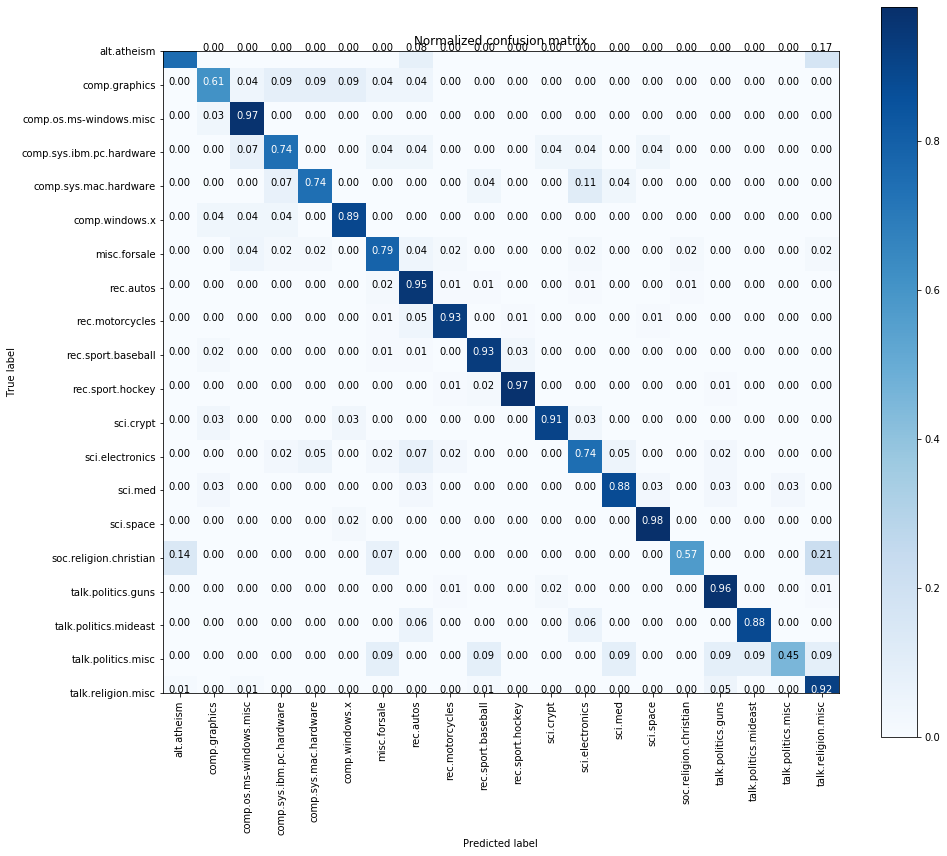

In [38]:
text_labels = encoder.classes_

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    #print(test_files_names.iloc[i])
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #分成x类的个数/真实x类的总数
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(x_test);
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)) 

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=True,
                      title='Normalized confusion matrix')

cnf_matrix

In [39]:
cnf_matrix

array([[  9,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   2],
       [  0,  14,   1,   2,   2,   2,   1,   1,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   1,  28,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   2,  20,   0,   0,   1,   1,   0,   0,   0,   1,   1,
          0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   2,  20,   0,   0,   0,   0,   1,   0,   0,   3,
          1,   0,   0,   0,   0,   0,   0],
       [  0,   1,   1,   1,   0,  24,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   2,   1,   1,   0,  37,   2,   1,   0,   0,   0,   1,
          0,   0,   1,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   2, 114,   1,   1,   0,   0,   1,
          0,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   5, 102,   0,   1,  

In [40]:
y_train_labels = np.argmax(y_train, axis =1)
prediction = model.predict(x_test)
predictions = np.argmax(prediction, axis = 1)
y_test_labels = np.argmax(y_test, axis =1)

In [41]:
#The Kappa score tell you how much better, or worse, your classifier is than what would be expected by random chance. 
#If you were to randomly assign cases to classes (i.e. a kind of terribly uninformed classifier), you'd get some correct simply by chance. 
#Therefore, you will always find that the Kappa value is lower than the overall accuracy. 
#The Kappa index is however considered to be a more conservative measure than the overall classification accuracy. 
#Your KIA value is telling you essentially that your classifier is about 66% better than a random assignment of cases to the various classes. That's not bad!
#A kappa value of 1 represents perfect agreement, while a value of 0 represents no agreement.

from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test_labels, predictions)
cohen_score

0.8871034865659929

In [42]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test_labels, predictions)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.75       0.7        0.8        0.74074074 0.8        0.85714286
 0.80434783 0.87692308 0.95327103 0.94782609 0.9609375  0.90625
 0.8        0.8974359  0.94       0.8        0.93162393 0.9375
 0.83333333 0.90588235]
recall: [0.75       0.60869565 0.96551724 0.74074074 0.74074074 0.88888889
 0.78723404 0.95       0.92727273 0.93162393 0.96850394 0.90625
 0.74418605 0.875      0.97916667 0.57142857 0.96460177 0.88235294
 0.45454545 0.91666667]
fscore: [0.75       0.65116279 0.875      0.74074074 0.76923077 0.87272727
 0.79569892 0.912      0.94009217 0.93965517 0.96470588 0.90625
 0.77108434 0.88607595 0.95918367 0.66666667 0.94782609 0.90909091
 0.58823529 0.9112426 ]
support: [ 12  23  29  27  27  27  47 120 110 117 127  32  43  40  48  14 113  17
  11  84]


In [43]:
# Let's do SMOTE for class imbalance

In [47]:
#Let us try some sampling technique to remove class imbalance
from imblearn.over_sampling import SMOTE
#Over-sampling: SMOTE
#SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, 
#based on those that already exist. It works randomly picking a point from the minority class and computing 
#the k-nearest neighbors for this point.The synthetic points are added between the chosen point and its neighbors.
#We'll use ratio='minority' to resample the minority class.

# I have read that the SMOTE package is implemented for binary classification. 
# In the case of n classes, it creates additional examples for the smallest class. 
# need to balance all the classes by running the algorithm n-1 times?
smote = SMOTE('minority')

X_sm, y_sm = smote.fit_sample(x_train, y_train)
print(X_sm.shape, x_train.shape)
print(y_sm.shape, y_train.shape)

(4710, 15000) (4268, 15000)
(4710, 20) (4268, 20)


y_sm[1]

In [70]:
y_sm[2]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [81]:
res = encoder.inverse_transform(y_sm)
res[0]

'rec.autos'

In [76]:
from collections import Counter
Counter(res)

Counter({'rec.autos': 474,
         'comp.sys.mac.hardware': 131,
         'comp.graphics': 109,
         'sci.space': 154,
         'talk.politics.guns': 433,
         'sci.med': 149,
         'comp.sys.ibm.pc.hardware': 120,
         'rec.motorcycles': 488,
         'talk.religion.misc': 293,
         'sci.electronics': 148,
         'rec.sport.hockey': 473,
         'rec.sport.baseball': 480,
         'comp.windows.x': 118,
         'comp.os.ms-windows.misc': 107,
         'misc.forsale': 167,
         'sci.crypt': 179,
         'alt.atheism': 65,
         'talk.politics.mideast': 70,
         'talk.politics.misc': 488,
         'soc.religion.christian': 64})

In [77]:
res2 = encoder.inverse_transform(y_train)
len(res2)

4268

In [78]:
Counter(res2)

Counter({'rec.autos': 474,
         'comp.sys.mac.hardware': 131,
         'comp.graphics': 109,
         'sci.space': 154,
         'talk.politics.guns': 433,
         'sci.med': 149,
         'comp.sys.ibm.pc.hardware': 120,
         'rec.motorcycles': 488,
         'talk.religion.misc': 293,
         'sci.electronics': 148,
         'rec.sport.hockey': 473,
         'rec.sport.baseball': 480,
         'comp.windows.x': 118,
         'comp.os.ms-windows.misc': 107,
         'misc.forsale': 167,
         'sci.crypt': 179,
         'alt.atheism': 65,
         'talk.politics.mideast': 70,
         'talk.politics.misc': 46,
         'soc.religion.christian': 64})

In [84]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced' ,np.unique(y_train_labels) ,y_train_labels)
num_epochs =10
batch_size = 128
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    class_weight=class_weight,
                    validation_split=0.2)

Train on 3414 samples, validate on 854 samples
Epoch 1/10
3414/3414 [==============================] - 3s 994us/step - loss: 1.3066e-04 - accuracy: 1.0000 - val_loss: 0.2221 - val_accuracy: 0.9543
Epoch 2/10
3414/3414 [==============================] - 3s 976us/step - loss: 1.2245e-04 - accuracy: 1.0000 - val_loss: 0.2233 - val_accuracy: 0.9543
Epoch 3/10
3414/3414 [==============================] - 3s 1ms/step - loss: 9.9705e-05 - accuracy: 1.0000 - val_loss: 0.2244 - val_accuracy: 0.9543
Epoch 4/10
3414/3414 [==============================] - 4s 1ms/step - loss: 1.1771e-04 - accuracy: 1.0000 - val_loss: 0.2249 - val_accuracy: 0.9543
Epoch 5/10
3414/3414 [==============================] - 4s 1ms/step - loss: 9.0117e-05 - accuracy: 1.0000 - val_loss: 0.2252 - val_accuracy: 0.9543
Epoch 6/10
3414/3414 [==============================] - 4s 1ms/step - loss: 1.2542e-04 - accuracy: 1.0000 - val_loss: 0.2240 - val_accuracy: 0.9543
Epoch 7/10
3414/3414 [==============================] - 4s 1m

In [82]:
class_weight

array([3.28307692, 1.95779817, 1.99439252, 1.77833333, 1.62900763,
       1.80847458, 1.27784431, 0.45021097, 0.43729508, 0.44458333,
       0.45116279, 1.19217877, 1.44189189, 1.43221477, 1.38571429,
       3.334375  , 0.49284065, 3.04857143, 4.63913043, 0.72832765])

In [88]:
Counter(res2)['rec.autos']

474

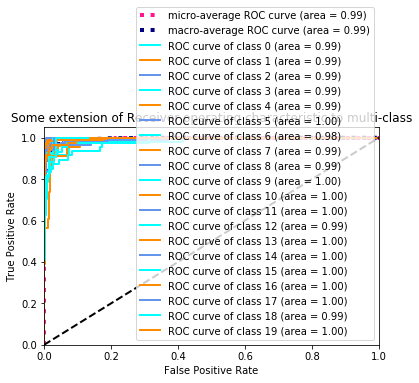

In [114]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), prediction.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [115]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 432x288 with 0 Axes>

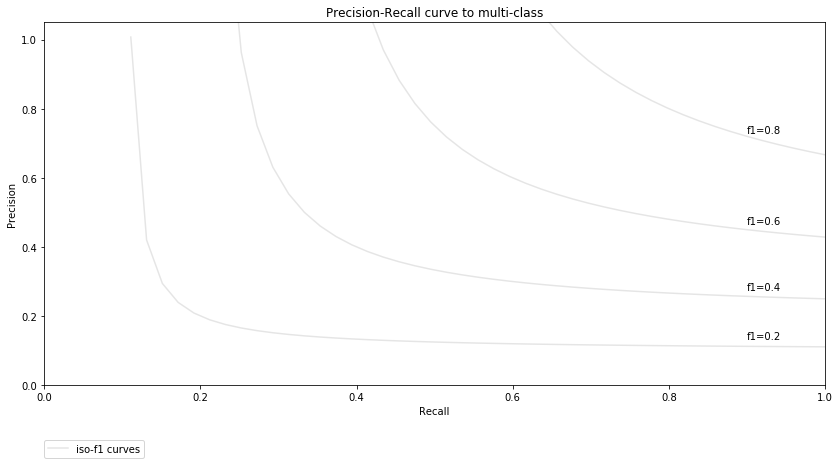

In [118]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(14, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
# l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
# lines.append(l)
# labels.append('micro-average Precision-recall (area = {0:0.2f})'
#               ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
#     labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
#                   ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()

In [119]:
recall[0]

0.75

In [21]:
import keras
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=2000)

17465344/17464789 [==============================] - 2s 0us/step


In [25]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 2,
 66,
 2,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 2,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2,
 19,
 14,
 22,
 4,
 1920,
 2,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2,
 2,
 16,
 480,
 66,
 2,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 2,
 15,
 256,
 4,
 2,
 7,
 2,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2,
 56,
 26,
 141,
 6,
 194,
 2,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 2,
 18,
 51,
 36,
 28,
 224,
 92,
 25,
 104,
 